In [176]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [177]:
# Set you source file path below as data_dir
data_dir="/Users/lakshminarasimman/Desktop/Breast_Cancer_Detection_from_Histopathological_Images/Image_Dataset"
data_dir = pathlib.Path(data_dir)

In [197]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

400


In [179]:
batch_size = 32
img_height = 180
img_width = 180

In [180]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 320 files for training.


In [181]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [182]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Insitu', 'Invasive', 'Normal']


2021-08-25 22:50:31.808640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 179 of 256
2021-08-25 22:50:36.062958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


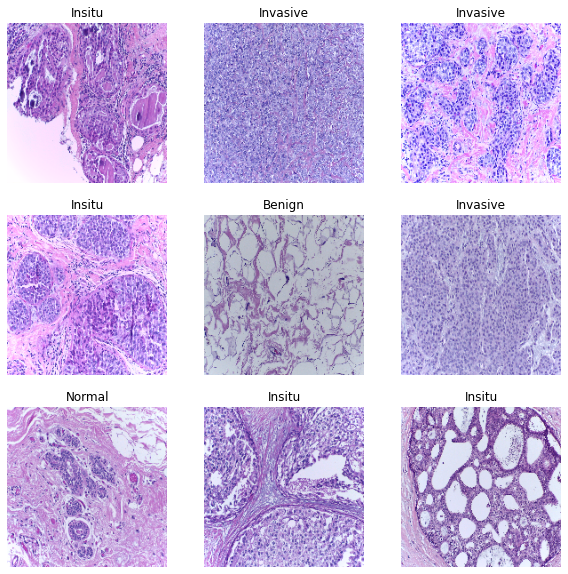

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [184]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2021-08-25 22:50:48.906628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 178 of 256
2021-08-25 22:50:53.228768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


(32, 180, 180, 3)
(32,)


In [185]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [186]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [187]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2021-08-25 22:51:05.142622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 167 of 256
2021-08-25 22:51:10.530400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-08-25 22:51:12.071173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000


0.10493147 1.0


2021-08-25 22:51:14.412815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [188]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

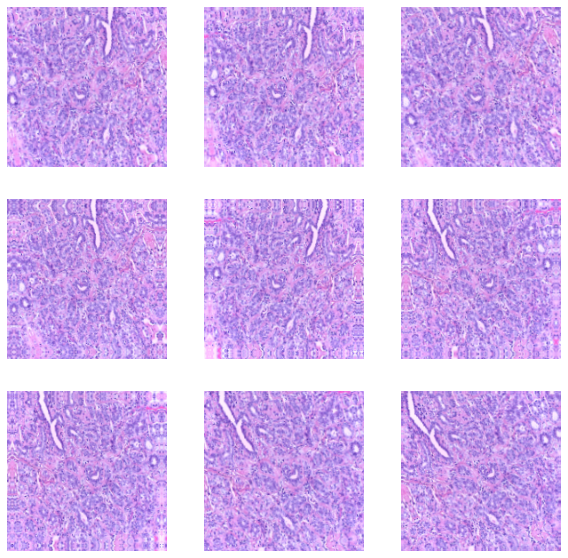

In [189]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [190]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [191]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [192]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 45, 45, 64)      

In [193]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
%time

Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 1.9904 - accuracy: 0.3063 - val_loss: 1.4377 - val_accuracy: 0.2750
Epoch 2/30
10/10 [==============================] - 8s 846ms/step - loss: 1.4570 - accuracy: 0.2406 - val_loss: 1.4047 - val_accuracy: 0.2750
Epoch 3/30
10/10 [==============================] - 8s 830ms/step - loss: 1.4260 - accuracy: 0.1906 - val_loss: 1.4327 - val_accuracy: 0.2000
Epoch 4/30
10/10 [==============================] - 8s 820ms/step - loss: 1.4199 - accuracy: 0.2531 - val_loss: 1.4014 - val_accuracy: 0.2750
Epoch 5/30
10/10 [==============================] - 8s 831ms/step - loss: 1.4062 - accuracy: 0.2375 - val_loss: 1.4055 - val_accuracy: 0.2000
Epoch 6/30
10/10 [==============================] - 8s 838ms/step - loss: 1.3862 - accuracy: 0.3094 - val_loss: 1.4275 - val_accuracy: 0.2000
Epoch 7/30
10/10 [==============================] - 8s 837ms/step - loss: 1.3992 - accuracy: 0.2562 - val_loss: 1.3975 - val_accuracy: 0.2000
Epoch 8/

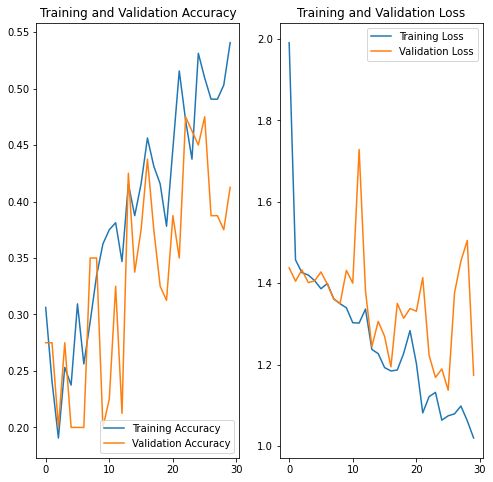

In [194]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [198]:
# Set unseen image file path below as histopathological_image_path
histopathological_image_path = "/Users/lakshminarasimman/Desktop/Breast_Cancer_Detection_from_Histopathological_Images/normal_breast.jpg"

img = keras.preprocessing.image.load_img(
    histopathological_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Normal with a 76.39 percent confidence.
